# 0 Preamble

## 0.1 Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from tpot import TPOTClassifier

import visuals as vs

# 1 Get data ready

## 1.1 Load data

I'll start by loading the data prepared by the [Living Income Analysis notebook](LivingIncomeAnalysis.ipynb)

In [2]:
data = pd.read_pickle('data_ready_for_ML.pkl')

In [3]:
data.describe()

,Number of household members living in the compound,Number of males over 65 years old,Number of females over 65 years old,Number of males 15-65,Number of females between 15 and 65 years old,Number of boys between 15 and 65 years old,Number of girls between 5 and 14 years old,Number of boys younger than 4 years old,Number of girls younger than 4 years old,Dependency ratio,...,3 meals/day: march,3 meals/day: april,3 meals/day: may,3 meals/day: june,3 meals/day: july,3 meals/day: august,3 meals/day: september,3 meals/day: october,3 meals/day: november,3 meals/day: december
count,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1349.000000,...,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000
mean,6.190476,0.133333,0.109158,1.734799,1.688645,0.979487,0.848352,0.354579,0.342125,1.011092,...,0.683370,0.674655,0.672476,0.662309,0.657952,0.661583,0.697168,0.708061,0.712418,0.724038
std,3.002501,0.369010,0.351719,1.221747,1.148336,1.096323,1.055501,0.671139,0.656139,1.011952,...,0.465331,0.468674,0.469481,0.473094,0.474568,0.473343,0.459650,0.454820,0.452799,0.447160
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,8.000000,0.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,21.000000,5.000000,5.000000,8.000000,9.000000,6.000000,6.000000,5.000000,5.000000,13.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.2 Fill in missing values

Since there are still a few missing values, I will fill these using the following strategy:

* For categorical variables, the mode
* For numerical variable, the median

In [4]:
# iterate through all features
for this_column in list(data.columns):

    # check if categorical
    if (str(data[this_column].dtype) == 'category') | (str(data[this_column].dtype) == 'object') :
        fill_value = data[this_column].mode()

    else:
        fill_value = data[this_column].median()
     
    # fill missing values
    data[this_column] = data[this_column].fillna(value = fill_value)

## 1.3 Split the target and features

I'll separate the target feature from the explanatory features

In [5]:
target = data['Living Income Achieved']
data.drop(['Living Income Achieved'], axis = 1, inplace = True)

## 1.4 one-hot encode

Now I turn the categorical feature in individual dummies

Let's first check the shape to see how many dummies will be created

In [6]:
data.shape

(1377, 608)

In [7]:
data = pd.get_dummies(data)

Now I can compare

In [8]:
data.shape

(1377, 838)

Let's investigate it more closely

In [9]:
list(data.columns)

['Number of household members living in the compound',
 'Number of males over 65 years old',
 'Number of females over 65 years old',
 'Number of males 15-65',
 'Number of females between 15 and 65 years old',
 'Number of boys between 15 and 65 years old',
 'Number of girls  between 5 and 14 years old',
 'Number of boys younger than 4 years old',
 'Number of girls younger than 4 years old',
 'Dependency ratio',
 'Head: age',
 'Female head',
 'All household boys ages 5 to 14 currently attending school',
 'All household girls ages 5 to 14 currently attending school',
 'Estimated income percentage from sale of cocoa',
 'Estimated income percentage from sale of other crops',
 'Estimated income percentage from sale of livestock or livestock products',
 'Estimated income percentage from sale of fish',
 'Estimated income percentage from sale of bush products (bush meat, charcoal, woo',
 'Estimated income percentage from labouring for other people on their farms',
 'Estimated income percentage 

## 1.5 Train test split

Let's split the data into the training and testing sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    train_size=0.75, test_size=0.25,
                                                   random_state = 32)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1032 samples.
Testing set has 345 samples.


Let's verify that training and testing set's have the same proportion of success of the target feature

In [11]:
target.value_counts()/len(target)

False    0.851126
True     0.148874
Name: Living Income Achieved, dtype: float64

In [12]:
y_train.value_counts()/len(y_train)

False    0.844961
True     0.155039
Name: Living Income Achieved, dtype: float64

In [13]:
y_test.value_counts()/len(y_test)

False    0.869565
True     0.130435
Name: Living Income Achieved, dtype: float64

# 2 Baseline classifier

I'll start with a Naive classifier to see what one would achieve with predicting the majority class. This will be used as baseline to compare the performance gain of the better trained classifiers

## 2.1 Naive Predictor on the majority class

In [14]:
TP = np.sum(target==0) # Counting the zeros as this is the naive case (majority class)
FP = target.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
naive_accuracy = (TP + TN)/(TP + TN + FP + FN)
naive_recall = TP/(TP + FN)
naive_precision = TP/(TP + FP)

# Calculate F-score using the formula for beta = 0.5 and correct values for precision and recall.
naive_fscore = (1+0.5**2)*(naive_precision*naive_recall)/((0.5**2)*naive_precision+naive_recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naive_accuracy, naive_fscore))
print("Naive Predictor: [Precision score: {:.4f}, Recall: {:.4f}]".format(naive_precision, naive_recall))

Naive Predictor: [Accuracy score: 0.8511, F-score: 0.8772]
Naive Predictor: [Precision score: 0.8511, Recall: 1.0000]


As we see from above, the accuracy (which in this special case is the same as the precision) is 85% for the majority class, with perfect recall, since all are predicted to not reach the living income)

# 3 Initial Classifiers

I'll first prepare a function that fits a classifier in a given sample size and prints some performance indicators

In [15]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train, predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [16]:
#  Initialize three models
clf_A = LogisticRegression(random_state=42)
clf_B = AdaBoostClassifier(random_state=42)
clf_C = KNeighborsClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set 
# samples_10 is 10% of samples_100
# samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    print("")
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


LogisticRegression trained on 10 samples.
LogisticRegression trained on 103 samples.


C:\Users\marcelot\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\marcelot\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

LogisticRegression trained on 1032 samples.

AdaBoostClassifier trained on 10 samples.
AdaBoostClassifier trained on 103 samples.
AdaBoostClassifier trained on 1032 samples.

KNeighborsClassifier trained on 10 samples.
KNeighborsClassifier trained on 103 samples.
KNeighborsClassifier trained on 1032 samples.


D:\ND DS\2. Intro to Data Science\Project (Blog post)\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


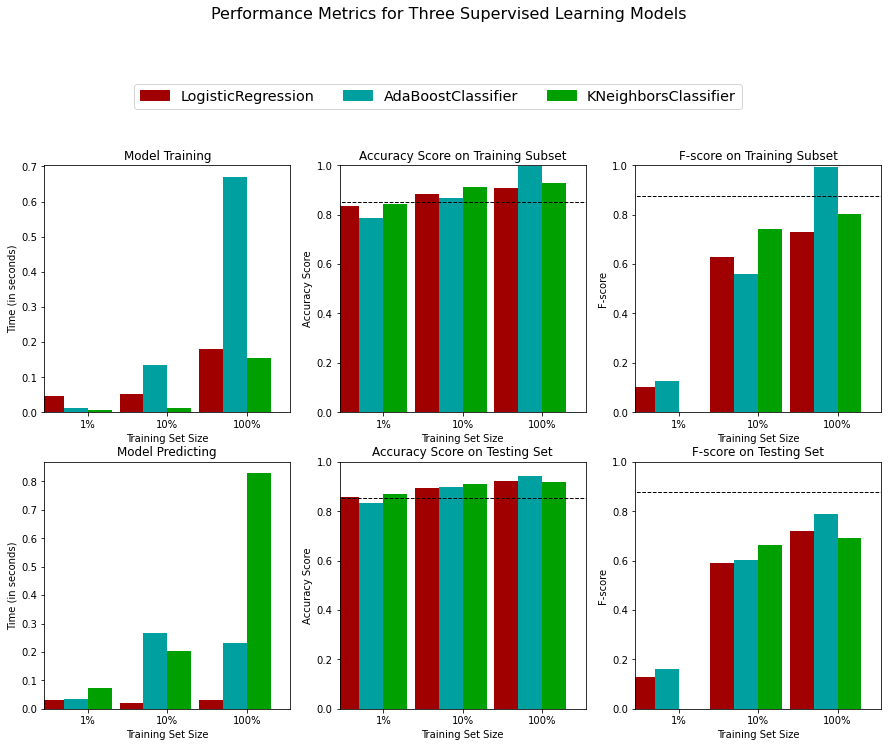

In [17]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, naive_accuracy, naive_fscore)

ADAboost seems to be best model, with the full sample size

In [18]:
adaBase_accuracy = results['AdaBoostClassifier'][2]['acc_test']
adaBase_fscore = results['AdaBoostClassifier'][2]['f_test']

In [19]:
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naive_accuracy, naive_fscore))
print("ADAboost, base Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaBase_accuracy, adaBase_fscore))

Naive Predictor: [Accuracy score: 0.8511, F-score: 0.8772]
ADAboost, base Predictor: [Accuracy score: 0.9420, F-score: 0.7895]


# 4 Grid search on the most promising classifier

To improve on that, I'll perform a grid search on the ADAboost parameters

In [20]:
# Create the parameters list to tune
parameters = {'n_estimators':[10, 50, 500, 1200, 1500, 2000],'learning_rate':[1.0,1.5,2.0]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta= 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf_B, parameters, scoring = scorer, verbose=1, n_jobs = -1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions 
best_predictions = best_clf.predict(X_test)

# metrics
adaOptim_accuracy = accuracy_score(y_test, best_predictions)
adaOptim_fscore = fbeta_score(y_test, best_predictions, beta = 0.5)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(adaBase_accuracy))
print("F-score on testing data: {:.4f}".format(adaBase_fscore))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(adaOptim_accuracy))
print("Final F-score on the testing data: {:.4f}".format(adaOptim_fscore))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.4min finished


Unoptimized model
------
Accuracy score on testing data: 0.9420
F-score on testing data: 0.7895

Optimized Model
------
Final accuracy score on the testing data: 0.9623
Final F-score on the testing data: 0.8597


In [21]:
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naive_accuracy, naive_fscore))
print("ADAboost, base Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaBase_accuracy, adaBase_fscore))
print("ADAboost, Optimized Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaOptim_accuracy, adaOptim_fscore))

Naive Predictor: [Accuracy score: 0.8511, F-score: 0.8772]
ADAboost, base Predictor: [Accuracy score: 0.9420, F-score: 0.7895]
ADAboost, Optimized Predictor: [Accuracy score: 0.9623, F-score: 0.8597]


Let's check the metrics more in details, checking the metrics per class

In [103]:
precision_recall_fscore_support(y_test, best_predictions, beta = 0.5)

(array([0.97674419, 0.86363636]),
 array([0.98      , 0.84444444]),
 array([0.97739362, 0.85972851]),
 array([300,  45], dtype=int64))

In [23]:
confusion_matrix(y_test, best_predictions)

array([[294,   6],
       [  7,  38]], dtype=int64)

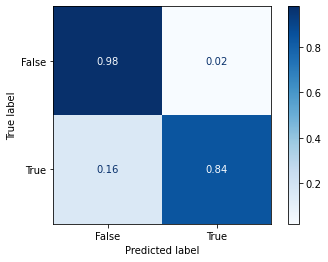

In [24]:
plot_confusion_matrix(best_clf, 
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize = 'true');

Let's check the most important feature

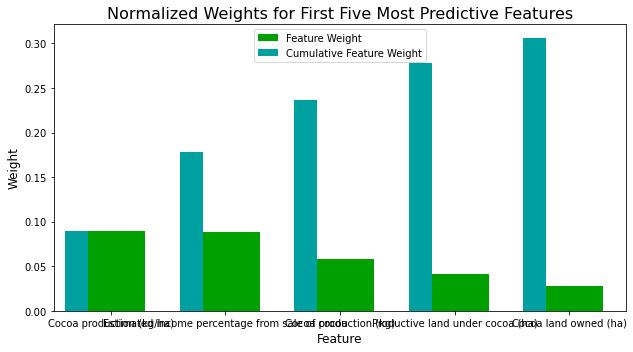

In [25]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [26]:
pd.DataFrame({'col_name': best_clf.feature_importances_}, index=data.columns).sort_values(by='col_name', ascending=False).head(n=20)

,col_name
Cocoa production (kg/ha),0.0900
Estimated income percentage from sale of cocoa,0.0885
Cocoa production (kg),0.0585
Productive land under cocoa (ha),0.0415
Cocoa land owned (ha),0.0275
Hectares with trees between 5 and 25 years old,0.0240
Head: age,0.0230
Estimated income percentage from sale of other crops,0.0220
Estimated income percentage from own small business or trading,0.0215
Land used to cultivate all crops (ha),0.0160


Let's save the best model so far:

In [27]:
pkl_filename = 'ada_best.pkl'
pickle.dump(best_clf, open(pkl_filename, 'wb'))

# 5 Grid Search, using stratified shuffle split

Because this problem is highly skewed (few cases achieving the Living Income) it is likely the different splits of the cross validation have different shares of positive cases. To ensure this, I'll use stratified shuffle split

In [28]:
# Make sure it is stratified
cv_strat = StratifiedShuffleSplit(n_splits=5,
                                  test_size=0.2,
                                  random_state=42)

## Repeat previous part with the new CV
grid_obj_strat = GridSearchCV(clf_B, parameters, scoring = scorer, verbose=1,
                             cv = cv_strat, n_jobs = -1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_strat = grid_obj_strat.fit(X_train, y_train)

# Get the estimator
best_clf_strat = grid_fit_strat.best_estimator_

# Make predictions 
best_predictions_strat = best_clf_strat.predict(X_test)

# metrics
adaOptimStrat_accuracy = accuracy_score(y_test, best_predictions_strat)
adaOptimStrat_fscore = fbeta_score(y_test, best_predictions_strat, beta = 0.5)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(adaBase_accuracy))
print("F-score on testing data: {:.4f}".format(adaBase_fscore))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(adaOptim_accuracy))
print("Final F-score on the testing data: {:.4f}".format(adaOptim_fscore))
print("\nOptimized Model with stratification\n------")
print("Final accuracy score on the testing data: {:.4f}".format(adaOptimStrat_accuracy))
print("Final F-score on the testing data: {:.4f}".format(adaOptimStrat_fscore))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.1min finished


Unoptimized model
------
Accuracy score on testing data: 0.9420
F-score on testing data: 0.7895

Optimized Model
------
Final accuracy score on the testing data: 0.9623
Final F-score on the testing data: 0.8597

Optimized Model with stratification
------
Final accuracy score on the testing data: 0.9652
Final F-score on the testing data: 0.8667


In [29]:
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naive_accuracy, naive_fscore))
print("ADAboost, base Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaBase_accuracy, adaBase_fscore))
print("ADAboost, Optimized Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaOptim_accuracy, adaOptim_fscore))
print("ADAboost, Optimized Stratified Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaOptimStrat_accuracy, adaOptimStrat_fscore))

Naive Predictor: [Accuracy score: 0.8511, F-score: 0.8772]
ADAboost, base Predictor: [Accuracy score: 0.9420, F-score: 0.7895]
ADAboost, Optimized Predictor: [Accuracy score: 0.9623, F-score: 0.8597]
ADAboost, Optimized Stratified Predictor: [Accuracy score: 0.9652, F-score: 0.8667]


In [30]:
print(best_clf_strat)
print("Best score (Stratified):", grid_fit_strat.best_score_)
pd.concat([pd.DataFrame(grid_fit_strat.cv_results_["params"]),
           pd.DataFrame(grid_fit_strat.cv_results_["rank_test_score"],
                        columns=["Rank"]),
           pd.DataFrame(grid_fit_strat.cv_results_["mean_test_score"], 
                        columns=["F1 Score"])],axis=1)

AdaBoostClassifier(learning_rate=1.5, n_estimators=1500, random_state=42)
Best score (Stratified): 0.8607369737664989


,learning_rate,n_estimators,Rank,F1 Score
0,1.0,10,12,0.750027
1,1.0,50,2,0.859118
2,1.0,500,4,0.848211
3,1.0,1200,7,0.844772
4,1.0,1500,8,0.844740
5,1.0,2000,9,0.842668
6,1.5,10,11,0.761622
7,1.5,50,10,0.819073
8,1.5,500,6,0.846838
9,1.5,1200,5,0.848153


Let's look into more detail:

In [99]:
precision_recall_fscore_support(y_test, best_predictions_strat, beta = 0.5)

(array([0.98      , 0.86666667]),
 array([0.98      , 0.86666667]),
 array([0.98      , 0.86666667]),
 array([300,  45], dtype=int64))

In [32]:
confusion_matrix(y_test, best_predictions_strat)

array([[294,   6],
       [  6,  39]], dtype=int64)

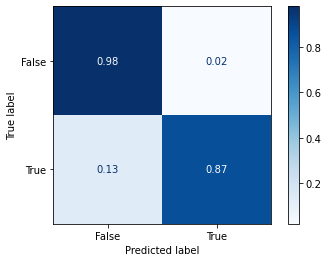

In [33]:
plot_confusion_matrix(best_clf_strat, 
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize = 'true');

In [34]:
pd.DataFrame({'col_name': best_clf_strat.feature_importances_}, index=data.columns).sort_values(by='col_name', ascending=False).head(n=20)

,col_name
Estimated income percentage from sale of cocoa,0.092667
Cocoa production (kg/ha),0.090667
Cocoa production (kg),0.059333
Productive land under cocoa (ha),0.042000
Cocoa land owned (ha),0.029333
Hectares with trees between 5 and 25 years old,0.022000
Estimated income percentage from own small business or trading,0.021333
Head: age,0.020667
Estimated income percentage from sale of other crops,0.020000
Land used to cultivate all crops (ha),0.014667


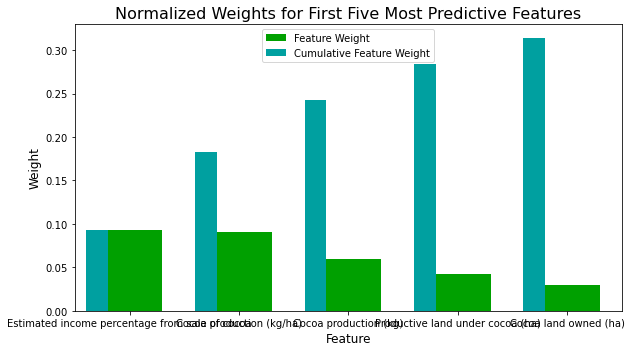

In [35]:
vs.feature_plot(best_clf_strat.feature_importances_, X_train, y_train)

Let's save the best model so far:

In [36]:
pkl_filename = 'ada_best_strat.pkl'
pickle.dump(best_clf_strat, open(pkl_filename, 'wb'))

# 6 Search using TPOT

I'll use TPOT in the Stratified Grid, to explore a more extensive space

In [37]:
pipeline_optimizer = TPOTClassifier()

In [38]:
pipeline_optimizer = TPOTClassifier(verbosity=2,
                                     n_jobs = -1,
                                    random_state = 32,
                                   periodic_checkpoint_folder = "intermediate_results",
                                    cv = cv_strat,
                                    scoring = scorer
                                   )

In [39]:
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))
pipeline_optimizer.export('tpot_exported_pipeline.py')


Generation 1 - Current best internal CV score: 0.8868528056383844
Generation 2 - Current best internal CV score: 0.8868528056383844
Generation 3 - Current best internal CV score: 0.8911435786435786
Generation 4 - Current best internal CV score: 0.8911435786435786
Generation 5 - Current best internal CV score: 0.8937494870883029
Generation 6 - Current best internal CV score: 0.8937494870883029
Generation 7 - Current best internal CV score: 0.8952281158163512
Generation 8 - Current best internal CV score: 0.8952281158163512
Generation 9 - Current best internal CV score: 0.8952281158163512
Generation 10 - Current best internal CV score: 0.8952281158163512
Generation 11 - Current best internal CV score: 0.8952281158163512
Generation 12 - Current best internal CV score: 0.8952281158163512
Generation 13 - Current best internal CV score: 0.9041110841620179
Generation 14 - Current best internal CV score: 0.9094864449703157
Generation 15 - Current best internal CV score: 0.9094864449703157
Gen

In [71]:
print(pipeline_optimizer.score(X_test, y_test))

0.873015873015873


In [72]:
tpot_pred = pipeline_optimizer.predict(X_test)

In [73]:
# metrics
tpot_accuracy = accuracy_score(y_test, tpot_pred)
tpot_fscore = fbeta_score(y_test, tpot_pred, beta = 0.5)

In [74]:
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naive_accuracy, naive_fscore))
print("ADAboost, base Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaBase_accuracy, adaBase_fscore))
print("ADAboost, Optimized Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaOptim_accuracy, adaOptim_fscore))
print("ADAboost, Optimized Stratified Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaOptimStrat_accuracy, adaOptimStrat_fscore))
print("TPOT Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(tpot_accuracy, tpot_fscore))

Naive Predictor: [Accuracy score: 0.8511, F-score: 0.8772]
ADAboost, base Predictor: [Accuracy score: 0.9420, F-score: 0.7895]
ADAboost, Optimized Predictor: [Accuracy score: 0.9623, F-score: 0.8597]
ADAboost, Optimized Stratified Predictor: [Accuracy score: 0.9652, F-score: 0.8667]
TPOT Predictor: [Accuracy score: 0.9565, F-score: 0.8730]


In [110]:
precision_recall_fscore_support(y_test, tpot_pred, beta = 0.5)

(array([0.96116505, 0.91666667]),
 array([0.99      , 0.73333333]),
 array([0.96679688, 0.87301587]),
 array([300,  45], dtype=int64))

In [76]:
confusion_matrix(y_test, tpot_pred)

array([[297,   3],
       [ 12,  33]], dtype=int64)

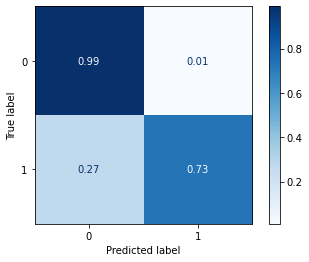

In [77]:
cm = confusion_matrix(y_test, tpot_pred, normalize = 'true')

cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

Save best model

In [79]:
TPOT_exported_pipeline = pipeline_optimizer.fitted_pipeline_

In [80]:
tpot_results = TPOT_exported_pipeline.predict(X_test)

In [100]:
precision_recall_fscore_support(y_test, tpot_results, beta = 0.5)

(array([0.96116505, 0.91666667]),
 array([0.99      , 0.73333333]),
 array([0.96679688, 0.87301587]),
 array([300,  45], dtype=int64))

In [82]:
pkl_filename = 'tpot_best_fitted.pkl'
pickle.dump(TPOT_exported_pipeline, open(pkl_filename, 'wb'))

# 7 Final model selection

Let's compare the best models:

|           | ADAboost        |         | TPOT            |         |
|-----------|-----------------|---------|-----------------|---------|
| accuracy  | 96.5%           |         | 95.6%           |         |
|           | _Did not achieve_ | _Achieved_ | _Did not Achieve_ | _Achieved_ |
| precision | 98%             | 87%     | 96%             | 92%     |
| recall    | 98%             | 87%     | 99%             | 73%     |
| f-score   | 98%             | 87%     | 96.6%           | 87.3%   |

Because teh ADAboost is more balanced in precision and recall, I will prefer this model over the TPOT best pipeline

In [111]:
best_model =  best_clf_strat

In [112]:
pkl_filename = 'best_overall.pkl'
pickle.dump(best_model, open(pkl_filename, 'wb'))